# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [60]:
%matplotlib inline

from datetime import datetime
import os
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import bz2

from shapely.geometry import Point
from adjustText import adjust_text

---

## Download data

First, download the data using the link below

In [61]:
def pickle_df(df,pickle_file):
    compress = '.bz2' in pickle_file
    print('Writing df to pickle_file: ' + pickle_file)
    fd = bz2.open(pickle_file,'wb') if compress else open(pickle_file,'wb')
    pickle.dump(df,fd,pickle.HIGHEST_PROTOCOL)
    fd.close()

def unpickle_df(pickle_file):
    df = None
    compress = '.bz2' in pickle_file    
    print('Reading df from pickle_file: ' + pickle_file)
    fd =  bz2.open(pickle_file,'rb') if compress else open(pickle_file,'rb')
    df = pickle.load(fd)
    fd.close()
    return df


In [62]:
def get_tile_filename(data_type: str, year: int, quarter: int) -> str:
    month = (quarter-1)*3+1
    return f'{year}-{month:02d}-01_performance_{data_type}_tiles.zip'

def get_tile_url(data_type: str, year: int, quarter:int) -> str:
    url_base = f'https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type={data_type}/year={year}/quarter={quarter}/'
    return url_base + get_tile_filename(data_type, year, quarter)

def get_tile_df(data_type, year, quarter, state = None, force = False):
    state = str(state)
    tile_file = 'data/' + get_tile_filename(data_type, year, quarter)
    pickle_file = tile_file.replace('.zip','_df.pkl.bz2')

    # state_file = None if not state else pickle_file.replace("_df",f"_{state}_df")
    # # Check for state file, if requested.
    # if state and os.path.exists(state_file) and not force:
    #     print('Loading state file...')
    #     with bz2.open(state_file) as f:
    #         state_tiles = pickle.load(f)
    #     return state_tiles

    # Load full ookla_tiles
    if not os.path.exists(pickle_file) or force:
        print('reading ookla tiles from url')
        ookla_tiles = gp.read_file(get_tile_url(data_type,year,quarter))
        pickle_df(ookla_tiles, pickle_file)
    else:
        print(f'reading ookla tiles from pickle file {pickle_file}')
        ookla_tiles = unpickle_df(pickle_file)
    return ookla_tiles

    # if state:
    #     # TODO: Check if state_file exists and load from pickle if exists and not force
    #     if os.path.exists(state_file) and not force:
    #         with bz2.open(state_file) as f:
    #             state_tiles = pickle.load(f)
    #     else:
    #         state_df = get_state_census_df(year, state,force)
    #         state_tiles = gp.sjoin(ookla_tiles, state_df, how="inner", predicate="intersects")
    #         print(f'Writing state tiles file {state_file}')
    #         with bz2.open(state_file,'wb') as f:
    #             pickle.dump(state_tiles,f, pickle.HIGHEST_PROTOCOL)
    #     return state_tiles
    # else:
    #     return ookla_tiles




In [63]:
tile_url = get_tile_url("fixed", 2020, 2)
tile_url

'https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2020/quarter=2/2020-04-01_performance_fixed_tiles.zip'

In [64]:
# tiles = gp.read_file(tile_url)
# tiles = gp.read_file(tile_file)
tiles = get_tile_df('fixed',2020,2)


reading ookla tiles from pickle file data/2020-04-01_performance_fixed_tiles_df.pkl.bz2
Reading df from pickle_file: data/2020-04-01_performance_fixed_tiles_df.pkl.bz2


In [65]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


---

## Get county boundaries

Then, I’ll load the Kentucky county boundaries from the U.S. Census Bureau ftp site.

In [80]:
# zipfile of U.S. county boundaries
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
county_pickle_file = 'data/tl_2019_us_county_df.pkl.bz2'
if os.path.exists(county_pickle_file):
    counties = unpickle_df(county_pickle_file)
else:
    counties = gp.read_file(county_url)
    pickle_df(counties, county_pickle_file)

Reading df from pickle_file: data/tl_2019_us_county_df.pkl.bz2


In [81]:
# filter out the Kentucky fips code and reproject to match the tiles
# state = '24' # '21' is ky, '24', is md
# state_name = 'Maryland'
state = '21' # '21' is ky, '24', is md
state_name = 'Kentucky'

state_counties = counties.loc[counties['STATEFP'] == state].to_crs(4326) 

In [82]:
state_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
9,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,NaN,NaN,NaN,A,510875755,21152699,+36.7272577,-085.1360977,"POLYGON ((-85.23910 36.76983, -85.23443 36.786..."
58,21,003,00516848,21003,Allen,Allen County,06,H1,G4020,150,14540,NaN,A,891838779,19482100,+36.7507703,-086.1924580,"POLYGON ((-86.29580 36.85107, -86.29347 36.852..."
66,21,231,00516962,21231,Wayne,Wayne County,06,H1,G4020,NaN,NaN,NaN,A,1186690748,67283816,+36.8007715,-084.8265896,"POLYGON ((-85.04450 36.87093, -85.03908 36.874..."
133,21,209,00516951,21209,Scott,Scott County,06,H1,G4020,336,30460,NaN,A,729774435,9440820,+38.2857099,-084.5783405,"POLYGON ((-84.58054 38.47304, -84.58010 38.473..."
157,21,061,00516877,21061,Edmonson,Edmonson County,06,H1,G4020,150,14540,NaN,A,784468358,13258105,+37.2275136,-086.2180153,"POLYGON ((-86.39916 37.16990, -86.39932 37.170..."


---

## Join tiles to counties

Now I’ll join the tiles to the counties. I use how = "inner" because I only want to include counties that have at least 1 tile.

In [83]:
tiles_in_state_counties = gp.sjoin(tiles, state_counties, how="inner", predicate='intersects')

In [84]:
# convert to Mbps for easier reading
tiles_in_state_counties['avg_d_mbps'] = tiles_in_state_counties['avg_d_kbps'] / 1000
tiles_in_state_counties['avg_u_mbps'] = tiles_in_state_counties['avg_u_kbps'] / 1000

In [85]:
tiles_in_state_counties.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,STATEFP,COUNTYFP,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,avg_d_mbps,avg_u_mbps
370,0320003031132232,236452,55959,40,37,11,"POLYGON ((-85.85815 38.13888, -85.85266 38.138...",2534,21,111,...,350,31140,NaN,C,986032282,43964666,+38.1895321,-085.6576243,236.452,55.959
1653,0320003121002010,128046,59741,42,76,13,"POLYGON ((-85.41870 38.23818, -85.41321 38.238...",2534,21,111,...,350,31140,NaN,C,986032282,43964666,+38.1895321,-085.6576243,128.046,59.741
2825,0320003102323032,228717,68654,38,18,10,"POLYGON ((-85.55054 38.29425, -85.54504 38.294...",2534,21,111,...,350,31140,NaN,C,986032282,43964666,+38.1895321,-085.6576243,228.717,68.654
8662,0320003120131011,6940,999,458,8,2,"POLYGON ((-85.45715 38.20366, -85.45166 38.203...",2534,21,111,...,350,31140,NaN,C,986032282,43964666,+38.1895321,-085.6576243,6.940,0.999
9703,0320003031131230,154782,59655,35,23,8,"POLYGON ((-85.81421 38.17775, -85.80872 38.177...",2534,21,111,...,350,31140,NaN,C,986032282,43964666,+38.1895321,-085.6576243,154.782,59.655


---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [86]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_state_counties.groupby(["GEOID", "NAMELSAD"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_state_counties.groupby(["GEOID", "NAMELSAD"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEOID", "NAMELSAD"],
    )
)

In [87]:
table_stats = (
    county_stats.loc[county_stats["tests"] >= 50]
    .nlargest(20, "avg_d_mbps_wt")
    .append(
        county_stats.loc[county_stats["tests"] >= 50].nsmallest(20, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

C:\Users\oren\AppData\Local\Temp\ipykernel_23664\1293078025.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  county_stats.loc[county_stats["tests"] >= 50]


In [88]:
header = ["GEOID", "County", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,GEOID,County,Avg download speed (Mbps),Tests
55,21111,Jefferson County,159.02,72699
33,21067,Fayette County,154.13,50730
104,21209,Scott County,151.21,6632
79,21159,Martin County,150.30,1489
23,21047,Christian County,146.73,5365
92,21185,Oldham County,144.92,9787
38,21077,Gallatin County,144.21,673
75,21151,Madison County,144.17,6097
24,21049,Clark County,144.07,2525
6,21013,Bell County,143.69,1165


---

## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The [census FTP site](ftp://ftp2.census.gov/geo/tiger/) makes it fairly easy to get a quick list!

In [89]:
county_data = state_counties[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(26916)

In [90]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

In [91]:
# add place labels 
state_places = gp.read_file(f"ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_{state}_place.zip")

In [92]:
state_places = state_places.loc[state_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
state_places["centroid"] = state_places["geometry"].centroid
state_places.set_geometry("centroid", inplace = True)

1

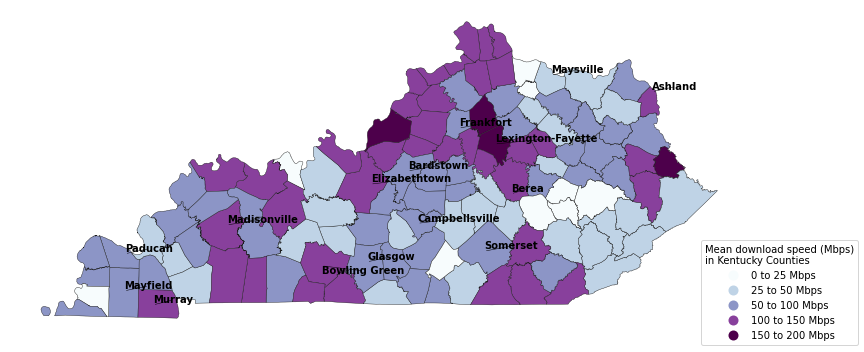

In [93]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title(f"Mean download speed (Mbps)\nin {state_name} Counties")

texts = []
for x, y, label in zip(state_places.geometry.x, state_places.geometry.y, state_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

adjust_text(
    texts,
    force_points=0.3,
    force_text=0.8,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)